In [11]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras import mixed_precision
import keras_tuner as kt


# Enable mixed precision for faster training and reduced memory usage
mixed_precision.set_global_policy("mixed_float16")

# Adjust threading for CPU (optional)
try:
    tf.config.threading.set_intra_op_parallelism_threads(16)
    tf.config.threading.set_inter_op_parallelism_threads(16)
except RuntimeError:
    print("⚠️ Threads must be set before TensorFlow runtime initialization.")

AUTOTUNE = tf.data.AUTOTUNE

In [12]:
img_height = 128
img_width = 128
batch_size = 32

base_dir = os.getcwd()
train_dir = os.path.join(base_dir, "train_images")
test_dir  = os.path.join(base_dir, "test_images")

train_tensorflow = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

test_tensorflow = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

# Save class names BEFORE any dataset transformations
class_names = train_tensorflow.class_names
num_classes = len(class_names)
print("✅ Classes:", class_names)

Found 8012 files belonging to 7 classes.
Found 2003 files belonging to 7 classes.
✅ Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [13]:
normalization_layer = layers.Rescaling(1./255)

data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

train_prepared = (
    train_tensorflow
    .map(lambda x, y: (normalization_layer(data_augmentation(x)), y))
    .cache()
    .shuffle(500)
    .prefetch(buffer_size=AUTOTUNE)
)

test_prepared = (
    test_tensorflow
    .map(lambda x, y: (normalization_layer(x), y))
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

In [14]:
base_logdir = "logs/tensorboard_tuning"
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = os.path.join(base_logdir, timestamp)
os.makedirs(log_dir, exist_ok=True)

HP_LEARNING_RATE = kt.HyperParameters()
HP_LEARNING_RATE.Choice("learning_rate", [1e-3, 1e-4])  # Reduced tuning
HP_DENSE_UNITS = kt.HyperParameters()
HP_DENSE_UNITS.Choice("dense_units", [64, 128])
HP_DROPOUT = kt.HyperParameters()
HP_DROPOUT.Choice("dropout_rate", [0.3, 0.4])

0.3

In [15]:
def build_cnn(hp):
    model = models.Sequential([
        layers.Conv2D(
            filters=hp.Choice("filters_1", [16, 32, 48]),
            kernel_size=3,
            activation="relu",
            input_shape=(img_height, img_width, 3)
        ),
        layers.MaxPooling2D(),
        layers.Conv2D(
            filters=hp.Choice("filters_2", [32, 64, 96]),
            kernel_size=3,
            activation="relu"
        ),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(hp.Choice("dense_units", [64, 96, 128, 256]), activation="relu"),
        layers.Dropout(hp.Float("dropout", 0.25, 0.45, step=0.05)),
        layers.Dense(num_classes, activation="softmax")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float("learning_rate", 1e-4, 3e-3, sampling="log")
        ),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [16]:
def build_mlp(hp):
    model = models.Sequential([
        layers.Flatten(input_shape=(img_height, img_width, 3)),
        layers.Dense(hp.Choice("dense1_units", [128, 256, 384]), activation="relu"),
        layers.Dropout(hp.Float("dropout1", 0.25, 0.45, step=0.05)),
        layers.Dense(hp.Choice("dense2_units", [64, 128, 192]), activation="relu"),
        layers.Dropout(hp.Float("dropout2", 0.25, 0.45, step=0.05)),
        layers.Dense(num_classes, activation="softmax")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float("learning_rate", 1e-4, 3e-3, sampling="log")
        ),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [17]:
def tune_model(model_builder, model_name, max_trials=10, executions_per_trial=1):
    tuner_logdir = os.path.join(log_dir, f"{model_name}_tuner")

    tuner = kt.BayesianOptimization(
        model_builder,
        objective="val_accuracy",
        max_trials=max_trials,
        executions_per_trial=executions_per_trial,
        directory=tuner_logdir,
        project_name=model_name
    )

    stop_early = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

    tuner.search(
        train_prepared,
        validation_data=test_prepared,
        epochs=5,
        callbacks=[stop_early, TensorBoard(log_dir=tuner_logdir)]
    )

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f"\n🏆 Best Hyperparameters for {model_name}:")
    for param, value in best_hps.values.items():
        print(f"  - {param}: {value}")

    best_model = tuner.hypermodel.build(best_hps)

    history = best_model.fit(
        train_prepared,
        validation_data=test_prepared,
        epochs=10,
        callbacks=[
            stop_early,
            ModelCheckpoint(filepath=f"{model_name}_best.keras", save_best_only=True),
            TensorBoard(log_dir=tuner_logdir)
        ]
    )

    test_loss, test_acc = best_model.evaluate(test_prepared)
    print(f"\n✅ {model_name} Test Accuracy: {test_acc:.4f}")

    return best_model, history


In [18]:
cnn_model, cnn_history = tune_model(build_cnn, "CNN_Model")

Trial 10 Complete [00h 07m 12s]
val_accuracy: 0.7059410810470581

Best val_accuracy So Far: 0.7124313712120056
Total elapsed time: 00h 50m 48s

🏆 Best Hyperparameters for CNN_Model:
  - filters_1: 48
  - filters_2: 96
  - dense_units: 128
  - dropout: 0.45
  - learning_rate: 0.00014043791065651145
Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 162s 641ms/step - accuracy: 0.6651 - loss: 1.0576 - val_accuracy: 0.6715 - val_loss: 0.9041
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 157s 627ms/step - accuracy: 0.6717 - loss: 0.9117 - val_accuracy: 0.6765 - val_loss: 0.8455
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 154s 613ms/step - accuracy: 0.6836 - loss: 0.8514 - val_accuracy: 0.6930 - val_loss: 0.8283
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 160s 639ms/step - accuracy: 0.6893 - loss: 0.8193 - val_accuracy: 0.6995 - val_loss: 0.7832
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 166s 661ms/step - accuracy: 0.6983 - loss: 0.7901 - val_accuracy: 0.7114 - val_loss: 0.7971
Epoch 6/10
 92/251 ━━━━━━━━━━━━━━━━━━━━ 1

KeyboardInterrupt: 

In [ ]:
mlp_model, mlp_history = tune_model(build_mlp, "MLP_Model")

Trial 10 Complete [00h 03m 24s]
val_accuracy: 0.6694957613945007

Best val_accuracy So Far: 0.6694957613945007
Total elapsed time: 00h 30m 14s

🏆 Best Hyperparameters for MLP_Model:
  - dense1_units: 256
  - dropout1: 0.4
  - dense2_units: 128
  - dropout2: 0.3
  - learning_rate: 0.001
  - tuner/epochs: 2
  - tuner/initial_epoch: 0
  - tuner/bracket: 1
  - tuner/round: 0
Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 159ms/step - accuracy: 0.6222 - loss: 3.1547 - val_accuracy: 0.6695 - val_loss: 1.2353
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.6690 - loss: 1.1793 - val_accuracy: 0.6695 - val_loss: 1.1370
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 43s 170ms/step - accuracy: 0.6670 - loss: 1.1727 - val_accuracy: 0.6695 - val_loss: 1.1323
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 169ms/step - accuracy: 0.6695 - loss: 1.1394 - val_accuracy: 0.6695 - val_loss: 1.1309
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 43s 170ms/step - accuracy: 0.6695 - loss: 1.1383 - val_accurac

In [ ]:
cnn_acc = max(cnn_history.history["val_accuracy"])
mlp_acc = max(mlp_history.history["val_accuracy"])

if cnn_acc > mlp_acc:
    best_model, best_history, best_name = cnn_model, cnn_history, "CNN"
else:
    best_model, best_history, best_name = mlp_model, mlp_history, "MLP"

print(f"\n🏆 Final Selected Model: {best_name} (Val Accuracy = {max(best_history.history['val_accuracy']):.4f})")


🏆 Final Selected Model: CNN (Val Accuracy = 0.7074)


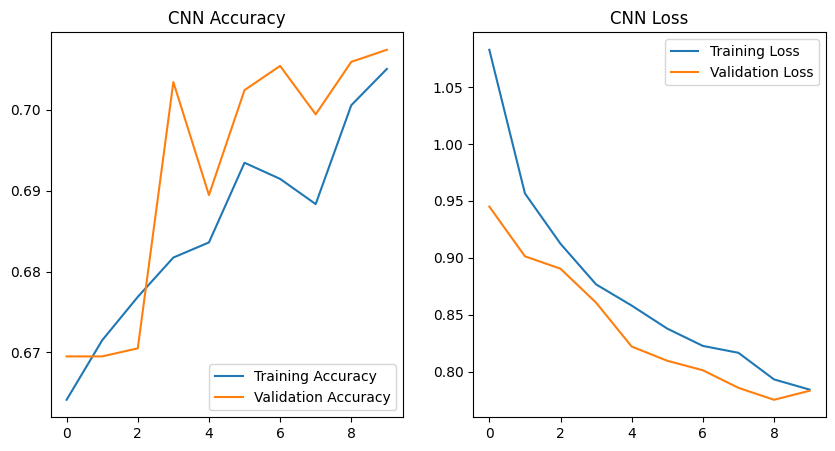

In [ ]:
acc = best_history.history["accuracy"]
val_acc = best_history.history["val_accuracy"]
loss = best_history.history["loss"]
val_loss = best_history.history["val_loss"]
epochs_range = range(len(acc))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend()
plt.title(f"{best_name} Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend()
plt.title(f"{best_name} Loss")
plt.show()

In [ ]:
print(f"\nFinal Evaluation on Test Set for {best_name}:")
test_loss, test_acc = best_model.evaluate(test_prepared)
print(f"Test Accuracy: {test_acc:.4f}")


Final Evaluation on Test Set for CNN:
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.7059 - loss: 0.7753
Test Accuracy: 0.7059
